In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os
print(os.listdir("../input"))

## ML Imports
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Processing and Metric Imports
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV

['train.csv', 'sample_submission.csv', 'test.csv']


In [4]:
# Data Retrieval
df = pd.read_csv('../input/train.csv')
backup = df.copy()
# Split into Training Data and Target
X_ids = df['Id']
X = df.drop(['Id', 'SalePrice'], axis=1)
y = df.loc[:, ['SalePrice']]

---
# EDA and Initial Guesses
* Big Picture, Correlation,  PDPs, Outliers

**Big Picture Look at SalePrices**
* Most prices around the upper 100k to lower 200k
* Interestingly, two houses > 700k

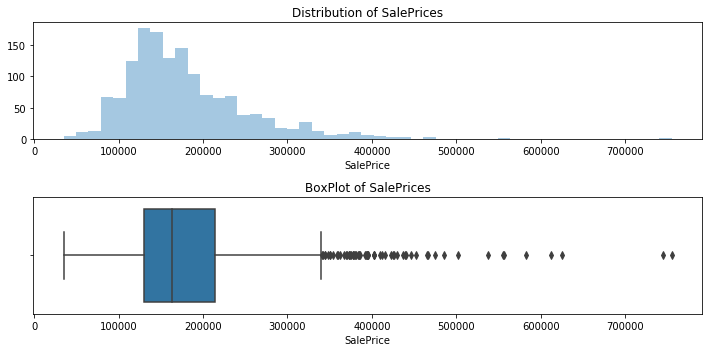

In [5]:
# Outliers
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 5))
sns.distplot(df['SalePrice'], kde=False, ax=ax[0])
ax[0].set_title('Distribution of SalePrices')
sns.boxplot(y='SalePrice', data=df, orient='h', ax=ax[1])
ax[1].set_title('BoxPlot of SalePrices')
plt.tight_layout()

**Correlations**
* Curious to see which features share the most linear relationship with SalePrice

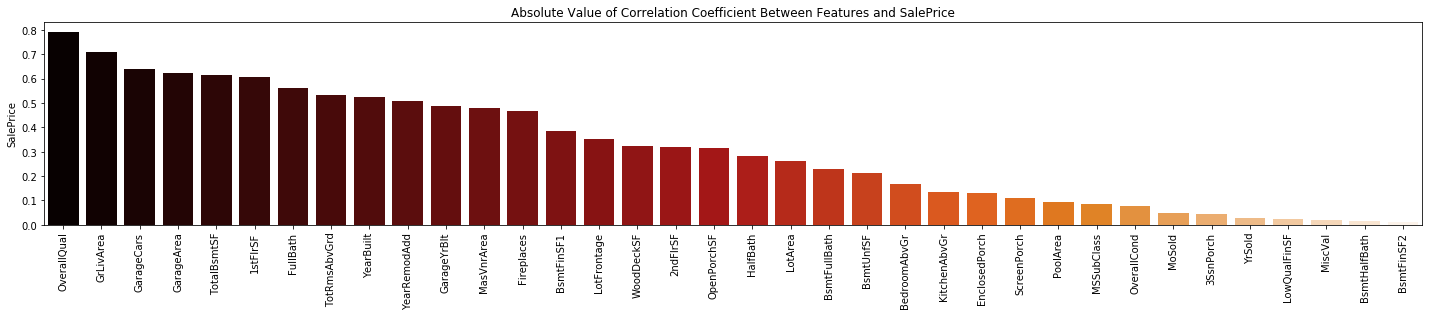

In [6]:
fig, axes = plt.subplots(figsize=(20, 4.5))
saleprice_corr = np.abs(df.drop(['Id'], axis=1).corr()['SalePrice']).sort_values(ascending=False)[1:]
sns.barplot(x=saleprice_corr.index, y=saleprice_corr, palette='gist_heat')
plt.title('Absolute Value of Correlation Coefficient Between Features and SalePrice')
plt.xticks(rotation='90')
plt.tight_layout();

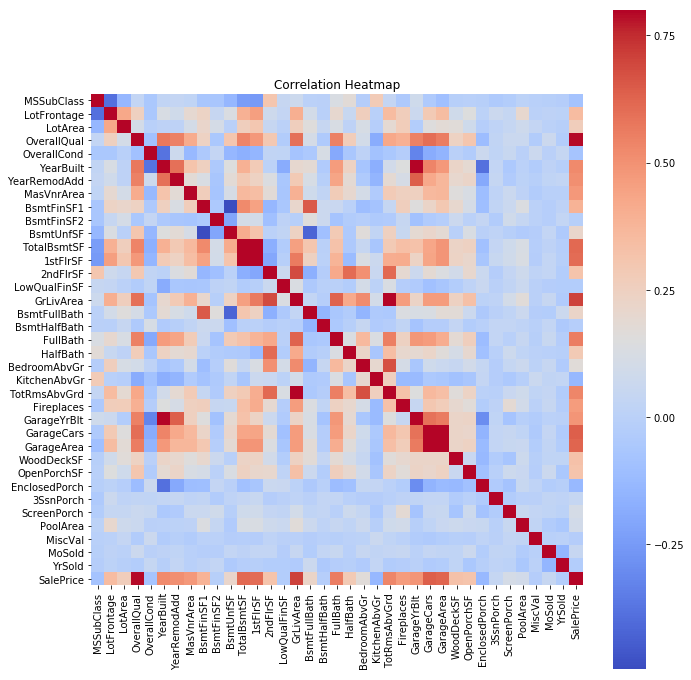

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
sns.heatmap(df.drop(['Id'], axis=1).corr(), vmax=.8, square=True, cmap='coolwarm', ax=axes)
plt.title('Correlation Heatmap')
plt.tight_layout()

## Missing Data

In [8]:
# Percent Missing in Each Column
missing_amts = np.around(100*X.isnull().sum()/X.shape[0], 2)
print(missing_amts[missing_amts > 10].sort_values(ascending=False).to_string())

PoolQC         99.52
MiscFeature    96.30
Alley          93.77
Fence          80.75
FireplaceQu    47.26
LotFrontage    17.74


**PoolQC, MiscFeature, Alley, Fence, and FireplaceQu** have > 40% of missing data. It may be worth investigating which  of these would be best removed for the model.

___
# Basic RandomForestRegressor Model

___
# Preprocessing Pipeline Creation

In [9]:
class ImputationIndicators(BaseEstimator, TransformerMixin):
    """Create columns indicating whether a column underwent imputation.

    For columns with missing values, another bool column is created with
    naming convention {column's name}_was_missing, indicating this.
    """
    def fit(self, x, y=None):
        return self

    def transform(self, X):
        cols_with_missing_values = (col for col in X.columns if X[col].isnull().any())
        for col in cols_with_missing_values:
            X[col + '_was_missing'] = X.loc[:, col].isnull()
        return X

In [8]:
class PandasOneHot(BaseEstimator, TransformerMixin):
    """One Hot Encoding of Categorical Variables

    Convert categorical variable to indicator variables.
    """
    def fit(self, x, y=None):
        return self

    def transform(self, X):
        return pd.get_dummies(X)

In [9]:
# This pipeline will create Imputation indicator columns and OneHot Encode Variables (imputation built-in on XGBoost Regressor)
my_pipeline = make_pipeline(ImputationIndicators(), PandasOneHot())

___
# Basic RandomForestRegressor Model
For investigating features etc.

In [10]:
# Split Dataset
# Data Retrieval
df = pd.read_csv('../input/train.csv')
backup = df.copy()
# Split into Training Data and Target
X_ids = df['Id']
X = df.drop(['Id', 'SalePrice'], axis=1)
y = df.loc[:, ['SalePrice']]
train_X, valid_X, train_y, valid_y = train_test_split(my_pipeline.fit_transform(X), y, random_state=7, test_size=0.1)

In [11]:
rf_pipeline = make_pipeline(Imputer(), RandomForestRegressor());
rf_pipeline.fit(train_X, train_y.values.ravel());
print('MAE:', mean_absolute_error(rf_pipeline.predict(valid_X), valid_y))

# Consider Dropping Columns with Missing Values

In [14]:
from itertools import combinations
def get_subsets(s):
    for sz in range(len(s)):
        yield from combinations(s, sz)
bad_cols = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'] # missing_amts.sort_values(ascending=False).index[:5]

In [15]:
%%time
# Try a couple subsets
results = {k: 0 for k in get_subsets(bad_cols)}
for n in range(1, 10, 2):
    for bad_col_subset in list(get_subsets(bad_cols)):
        # Preparing Datasets
        train_X, valid_X, train_y, valid_y = train_test_split(my_pipeline.fit_transform(X.drop(list(bad_col_subset), axis=1)), y, test_size=0.1, random_state=7)

        # Pipeline Creation and Fitting
        rf_dropped_pipeline = make_pipeline(Imputer(), RandomForestRegressor())
        rf_dropped_pipeline.fit(train_X, train_y.values.ravel())

        results[bad_col_subset] += mean_absolute_error(rf_dropped_pipeline.predict(valid_X), valid_y)

In [34]:
[(t[0], t[1]/5) for t in sorted(results.items(), key = lambda x: x[1])[:5]]

In [18]:
# Without Dropping Columns (see if it is actually better to drop some of these columns)
# Preparing Datasets
train_X, valid_X, train_y, valid_y = train_test_split(my_pipeline.fit_transform(X), y, test_size=0.1, random_state=7)

# Pipeline Creation and Fitting
rf_dropped_pipeline = make_pipeline(Imputer(), RandomForestRegressor())
rf_dropped_pipeline.fit(train_X, train_y.values.ravel())

mean_absolute_error(rf_dropped_pipeline.predict(valid_X), valid_y)

### Use with Basic Model 

In [36]:
X_drop_bad_cols = X.drop(list(['PoolQC', 'MiscFeature', 'Alley']), axis=1)
# Split Dataset
train_X, valid_X, train_y, valid_y = train_test_split(my_pipeline.fit_transform(X_drop_bad_cols), y, random_state=7, test_size=0.1)
# Predict
rf_pipeline = make_pipeline(Imputer(), RandomForestRegressor());
rf_pipeline.fit(train_X, train_y.values.ravel());
print('MAE:', mean_absolute_error(rf_pipeline.predict(valid_X), valid_y))

---

# Model Tuning

## (1) max_depth and min_child_weight

In [ ]:
%%time
params = {'max_depth':range(3,10,2), 'min_child_weight':range(1,6,2)}
gsearch1 = GridSearchCV(estimator = XGBRegressor(learning_rate =0.11899942, n_estimators=10000, max_depth=5, min_child_weight=1, gamma=0, subsample=0.8 ,colsample_bytree=0.8),
                        return_train_score= True,
                        param_grid = params,
                        scoring='neg_mean_absolute_error',
                        n_jobs=-1, 
                        iid=False,
                        cv = 5)
gsearch1.fit(train_X, train_y)

In [ ]:
xgb = XGBRegressor(learning_rate= 0.11899942, n_estimators= 10000, max_depth= 5, min_child_weight= 1, gamma= 0, subsample= 0.8 , colsample_bytree= 0.8)
model = xgb.fit(train_X, train_y, eval_metric="rmse", early_stopping_rounds=233, eval_set=[(valid_X, valid_y)], verbose=False)
mean_absolute_error(model.predict(valid_X), valid_y)

### **Results: max_depth=3; min_child_weight=1**

## (2, 3, 4) gamma

In [ ]:
%%time
params = {'gamma':[i/10 for i in range(0,6)]}
gsearch2 = GridSearchCV(estimator = XGBRegressor(learning_rate =0.11899942, n_estimators=10000, max_depth=3, min_child_weight=1, gamma=0, subsample=0.8 ,colsample_bytree=0.8),
                        return_train_score= True,
                        param_grid = params,
                        scoring='neg_mean_absolute_error',
                        n_jobs=-1, 
                        iid=False,
                        cv = 3)
gsearch2.fit(train_X, train_y)

In [ ]:
pd.DataFrame(gsearch2.cv_results_).sort_values('mean_test_score', ascending=False).loc[:, ['param_gamma', 'mean_test_score']]

It seems that gamma of 0 and 0.1 are very close. Further testing in that range.

In [ ]:
%%time
params = {'gamma': np.linspace(0.05, 0.15, 11)}
gsearch3 = GridSearchCV(estimator = XGBRegressor(learning_rate =0.11899942, n_estimators=10000, max_depth=3, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8),
                        return_train_score= True,
                        param_grid = params,
                        scoring='neg_mean_absolute_error',
                        n_jobs=-1, 
                        iid=False,
                        cv = 3)
gsearch3.fit(train_X, train_y)

In [ ]:
pd.DataFrame(gsearch3.cv_results_).sort_values('mean_test_score', ascending=False).loc[:, ['param_gamma', 'mean_test_score']]

Narrowing down one last time.

In [ ]:
%%time
params = {'gamma': np.linspace(0.0085, 0.0095, 11)}
gsearch4 = GridSearchCV(estimator = XGBRegressor(learning_rate =0.11899942, n_estimators=10000, max_depth=3, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8),
                        return_train_score= True,
                        param_grid = params,
                        scoring='neg_mean_absolute_error',
                        n_jobs=-1, 
                        iid=False,
                        cv = 3)
gsearch4.fit(train_X, train_y)

In [ ]:
pd.DataFrame(gsearch4.cv_results_).sort_values('mean_test_score', ascending=False).loc[:, ['param_gamma', 'mean_test_score']]

### **Result: gamma = 0.0088**

## (5) subsample and colsample_bytree

In [ ]:
%%time
params = { 'subsample': np.linspace(0.6, 0.9, 4), 'colsample_bytree': np.linspace(0.6, 0.9, 4)}
gsearch5 = GridSearchCV(estimator = XGBRegressor(learning_rate =0.11899942, n_estimators=10000, max_depth=3, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8),
                        return_train_score= True,
                        param_grid = params,
                        scoring='neg_mean_absolute_error',
                        n_jobs=-1, 
                        iid=False,
                        cv = 3)
gsearch5.fit(train_X, train_y)

In [ ]:
pd.DataFrame(gsearch5.cv_results_).sort_values('mean_test_score', ascending=False).loc[:, ['params', 'mean_test_score']]

### **Result: colsample_bytree = 0.8; subsample=0.6**

***
# SUBMISSION

In [ ]:
# Data Retrieval
df = pd.read_csv('../input/train.csv')

# Drop columns that hinder the model's efficacy
drop_cols = ['MiscFeature', 'Alley', 'Fence', 'Id']
X = df.drop(drop_cols + ['SalePrice'], axis=1).copy()
y = df.loc[:, ['SalePrice']].copy()

# Submission Data
test = pd.read_csv('../input/test.csv').drop(drop_cols, axis=1).copy()
test_ids = pd.read_csv('../input/test.csv')['Id']

# Creation of columns indicating what will be imputed
cols_with_missing = (col for col in X.columns if X[col].isnull().any())
for col in cols_with_missing:
    X[col + '_was_missing'] = X.loc[:, col].isnull()
    test[col + '_was_missing'] = test.loc[:, col].isnull()
assert X.shape[1] == test.shape[1], "Imputation Indicator # Columns Mismatch"

# One-hot encode training predictors and align test data to it
one_hot_encoded_train_predictors = pd.get_dummies(X)
one_hot_encoded_train_predictors, final_test = one_hot_encoded_train_predictors.align(pd.get_dummies(test), join='inner', axis=1)

# Split Dataset
train_X, valid_X, train_y, valid_y = train_test_split(one_hot_encoded_train_predictors, y, random_state=7, test_size=0.1)

In [ ]:
# Model Training
xgb = XGBRegressor(n_estimators=10000, learning_rate=0.11899942, n_jobs=-1, max_depth=3, min_child_weight=1, gamma=0.0088)
model = xgb.fit(train_X, train_y, eval_metric="rmse", early_stopping_rounds=233, eval_set=[(valid_X, valid_y)], verbose=False)

In [ ]:
mean_absolute_error(model.predict(valid_X), valid_y) #13916.308968321919

# Final Submission


In [ ]:
predictions = model.predict(final_test)
my_submission = pd.DataFrame({'Id': test_ids, 'SalePrice': predictions})
my_submission.to_csv('submission.csv', index=False)